In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets

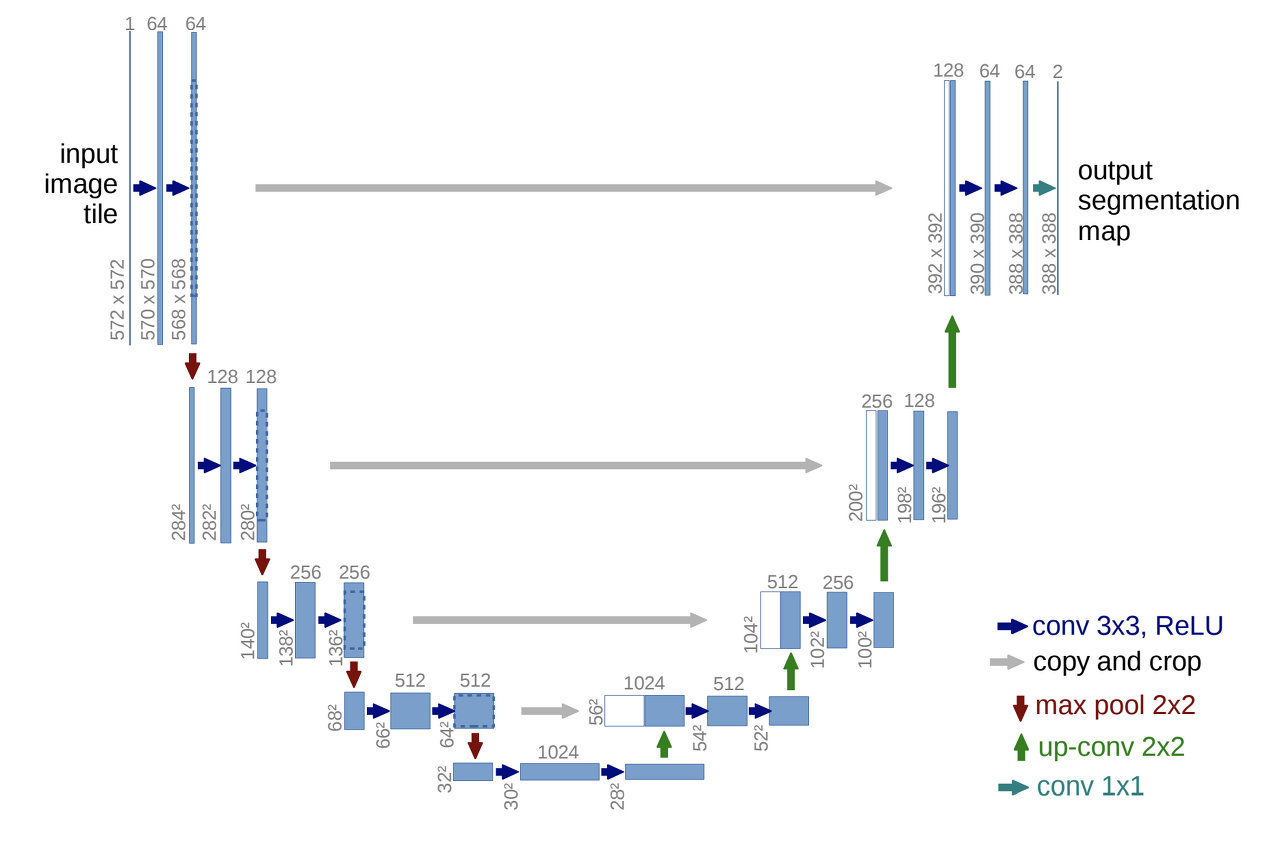

In [3]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
    def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        layers = []
        layers += [nn.Conv2d(
            in_channels  = in_channels,
            out_channels = out_channels,
            kernel_size  = kernel_size,
            stride       = stride,
            padding      = padding,
            bias         = bias
            )]
        layers += [nn.BatchNorm2d(num_features=out_channels)]
        layers += [nn.ReLU()]
        
        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        
        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec4_2 = CBR2d(in_channels=512*2, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec3_2 = CBR2d(in_channels=256*2, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec2_2 = CBR2d(in_channels=128*2, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec1_2 = CBR2d(in_channels=64*2, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1  = self.pool1(enc1_2)
        
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2  = self.pool2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3  = self.pool3(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4  = self.pool4(enc4_2)
        
        enc5_1 = self.enc5_1(pool4)
        
        dec5_1 = self.dec5_1(enc5_1)
        unpool4 = self.unpool4(dec5_1)
        
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        
        unpool3 = self.unpool3(dec4_1)
        
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.fc(dec1_1)
        
        return x
        